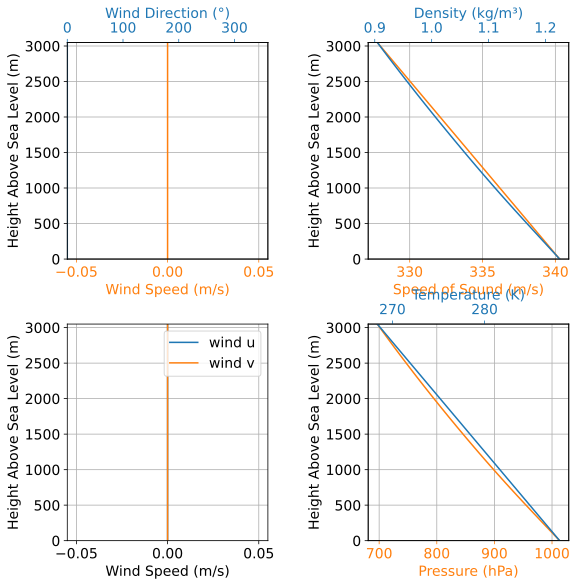

TOTAL SIMS IS: 40


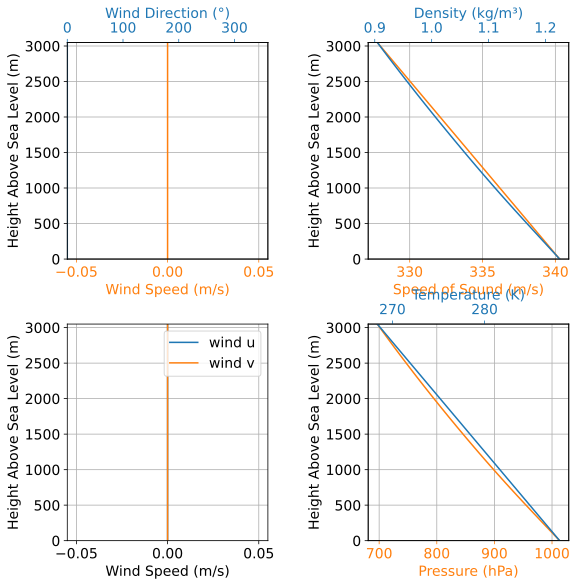

'Completed 40 iterations successfully. Total CPU time: 12.03125 s. Total wall time: 12.607092380523682 s'

c:\Users\mahd\Documents\SimulationRocketPy\rocketpy\simulation\flight.py:1238: UserWarning: time_overshoot has been set to False due to the presence of controllers or sensors. 
  warnings.warn(


E0: -0.3420071202466192, E1: -0.008200261012848266, E2: -0.002984650921890389, E3: -0.939656840170288
Angle from flat plane (deg): 89.0000000000001
The goddamn altitude: 0
The index is: 99
Altitude array:
[2500.         2505.53535354 2511.07070707 2516.60606061 2522.14141414
 2527.67676768 2533.21212121 2538.74747475 2544.28282828 2549.81818182
 2555.35353535 2560.88888889 2566.42424242 2571.95959596 2577.49494949
 2583.03030303 2588.56565657 2594.1010101  2599.63636364 2605.17171717
 2610.70707071 2616.24242424 2621.77777778 2627.31313131 2632.84848485
 2638.38383838 2643.91919192 2649.45454545 2654.98989899 2660.52525253
 2666.06060606 2671.5959596  2677.13131313 2682.66666667 2688.2020202
 2693.73737374 2699.27272727 2704.80808081 2710.34343434 2715.87878788
 2721.41414141 2726.94949495 2732.48484848 2738.02020202 2743.55555556
 2749.09090909 2754.62626263 2760.16161616 2765.6969697  2771.23232323
 2776.76767677 2782.3030303  2787.83838384 2793.37373737 2798.90909091
 2804.44444444 

c:\Users\mahd\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mahd\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\mahd\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mahd\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mahd\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

In [1]:
from time import process_time, time
import pandas as pd
from rocketpy import Environment, SolidMotor, Rocket, Flight
import concurrent.futures
from ConcurrentFunctions import runFlightWithMonteCarlo
from rocketpy.motors import motor
from IPython.display import display
from scipy.stats import norm
from rocketpy.mathutils.function import Function
from rocketpy.environment import environment

import datetime

#Calculate and plot landing elipses
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

import FlightParams

%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

from wind import makeWind

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14


import logging
import numpy as np

launchDate = [2025, 6, 12, 8]

# Iterate the loop to read the cell values
env = Environment(
    date=launchDate,
    latitude=FlightParams.envParams["latitude"],
    longitude=FlightParams.envParams["longitude"],
    max_expected_height=3050
)

env.set_atmospheric_model(type=FlightParams.envParams["type"], file=FlightParams.envParams["file"])
env.plots.atmospheric_model()

#env = Environment(latitude = FlightParams.envParams["latitude"], longitude = FlightParams.envParams["longitude"], elevation = FlightParams.envParams["elevation"])

analysis_parameters = {
    # Rocket's dry mass without motor (kg) and its uncertainty (standard deviation)
    "rocket_mass": (FlightParams.spMass, 0), #.001
    # # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "rocket_inertia_11": (FlightParams.spCentralDiameter, 0),
    # # Rocket's inertia moment relative to its axis (kg*m^2)
    "rocket_inertia_33": (FlightParams.spCentralAxis, 0),
    # Motors's dry mass without propellant (kg) and its uncertainty (standard deviation)
    "motor_dry_mass": (FlightParams.dryMotorMass, 0), #.001
    # # Motor's dry inertia moment perpendicular to its axis (kg*m^2)
    "motor_inertia_11": (FlightParams.motor_11_inertia, 0),
    # # Motors's dry inertia moment relative to its axis (kg*m^2)
    "motor_inertia_33": (FlightParams.motor_33_inertia, 0),\
    # Distance between rocket's center of dry mass and motor's center of dry mass (m)
    # THIS is likely wrong, go back to check it

    "motor_dry_mass_position": (np.abs(FlightParams.the_motor_center_of_dry_mass_position - FlightParams.rocket_center_of_dry_mass_position), 0), #.001
    # Motor total impulse (N*s)
    "impulse": (FlightParams.impulse, 0), #25.3

    "motor_position": (FlightParams.the_motor_position, 0),

    # Motor burn out time (s)
    "burn_time": (FlightParams.burn_time, 0),
    # Motor's nozzle radius (m)
    "nozzle_radius": (FlightParams.the_nozzle_radius, 0), #.5 / 1000
    # Motor's nozzle throat radius (m)
    "throat_radius": (FlightParams.the_throat_radius, 0), #.5 / 1000
    # Motor's grain separation (axial distance between two grains) (m)
    "grain_separation": (FlightParams.grainSeparation, 0),
    # Motor's grain density (kg/m^3)
    "grain_density": (FlightParams.motor_density, 0), #20
    # Motor's grain outer radius (m)
    "grain_outer_radius": (FlightParams.grainOuterRadius, 0),
    # Motor's grain inner radius (m)
    "grain_initial_inner_radius": (FlightParams.grainInnerRadius, 0), #.3 / 1000
    # Motor's grain height (m)
    "grain_initial_height": (FlightParams.grainHeight, 0), #1 / 1000
    # Rocket's radius (kg*m^2)
    "radius": (FlightParams.spRadius, 0),
    # Nozle position relative to motor
    "nozzle_position": (FlightParams.the_nozzle_position, 0),
    # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "grains_center_of_mass_position": (FlightParams.rocket_center_of_dry_mass_position-(FlightParams.the_motor_center_of_dry_mass_position + FlightParams.the_motor_position), 0), #.0001
    # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "nose_distance_to_CM": (FlightParams.rocket_center_of_dry_mass_position-FlightParams.nose_cone_length, 0),
    # Launch rail inclination angle relative to the horizontal plane (degrees)
    "inclination": (FlightParams.inclination, 0), #1
    # Launch rail heading relative to north (degrees)
    "heading": (FlightParams.heading, 0), #2
    # Drag coefficient times reference area for the drogue chute (m^2)
    "cd_s_drogue": (FlightParams.drogueCdS, 0), #.02
    # Drag coefficient times reference area for the light chute
    "cd_s_light": (FlightParams.lightCdS, 0), #.02
    # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    "lag_rec": (FlightParams.lag_rec, 0), #.2
    # Time delay between sensor signal is received and ejection signal is fired (s)
    "lag_se": (FlightParams.lag_se, 0), #.1
    # temperature in kelvin
    "temperature": (FlightParams.kelvin_temp, 0), #5
    # atmospheric pressure in pascals
    "atmosphere_pressure": (env.pressure_ISA(FlightParams.envParams["elevation"]), 0), #300

    #without motor
    "rocket_CM": (FlightParams.rocket_center_of_dry_mass_position, 0), #.01

    # adding these, but they don't vary
    "time_to_deploy_airbrake_after_burnout": (0.1, 0),
    "fin_position": (2.62, 0)
}

# M1850W.all_info()

#sets up the ability to log inputs.
def setup_logging():
    class MyHandler(logging.FileHandler):
        def emit(self, record):
            super().emit(record)  # Call the superclass's emit method
            self.flush()  # Flush after each log message

    # Use your custom handler
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    handler = MyHandler('app.log', 'a')
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

resultsFile = open(FlightParams.generatedFilesLocation + "results.txt", "w")

def createDistributionPlot(dispersonResultArray, name, lowerProbBound, upperProbBound, maxDecimals, percentConfidence, hypothesis, unit, makeGraph, filename):
    mean = np.mean(dispersonResultArray)
    deviation = np.std(dispersonResultArray)
    unitString = ""
    if(unit == "meters"):
        unitString = "m"
    print(
        f'{name} -         Mean Value: {mean:0.3f} ' + unitString
    )
    resultsFile.write(f'{name} -         Mean Value: {mean:0.3f} ' + unitString + "\n")
    print(
        f'{name} - Standard Deviation: {deviation:0.3f} m' + unitString
    )
    resultsFile.write(f'{name} - Standard Deviation: {deviation:0.3f} m' + unitString + "\n")
    if(makeGraph):

        print(f"Arr: {dispersonResultArray}")
        minimum = np.min(dispersonResultArray)
        maximum = np.max(dispersonResultArray)
        theBins = list()

        #using scott's rule to find the number of bins
        binWidth = 3.5 * deviation / np.power(len(dispersonResultArray), 1/3)
        numBins = int(np.round((maximum-minimum)/binWidth))

        changeInZ = (maximum - minimum) / numBins
        #test add
        zIterator = minimum
        for iterator in range(numBins):
            theBins.append(zIterator)
            zIterator += changeInZ
        finalValue = np.ceil(zIterator * np.power(10, maxDecimals)) / np.power(10, maxDecimals)
        theBins.append(finalValue)
        plt.figure()
        plt.xlim(minimum, maximum)
        minTextSize = 8
        maxTickCount = 50
        xTickBins = theBins
        if(numBins > maxTickCount):
            xTickBins = list()
            changeInZ = (maximum - minimum) / 50.0
            zIterator = minimum
            for iterator in range(50):
                xTickBins.append(zIterator)
                zIterator += changeInZ
        binListToString = list()
        for currentBin in xTickBins:
            binListToString.append(str(round(currentBin, maxDecimals)))
        plt.xticks(ticks = xTickBins, labels = binListToString, rotation = 75, fontsize = minTextSize)
        plt.hist(dispersonResultArray, bins=theBins)
        plt.title(name)
        plt.xlabel(name)
        plt.ylabel("Number of Occurences")

        plt.axvline(mean, color='k', linestyle='solid', linewidth=4)
        plt.axvline(mean - deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.savefig(FlightParams.generatedFilesLocation + str(filename) + "Graph.png", bbox_inches="tight", pad_inches=0)
        plt.show()
    lowerZ = (lowerProbBound - mean)/deviation
    upperZ = (upperProbBound - mean)/deviation
    probabilityInRange = norm.cdf(upperZ) - norm.cdf(lowerZ)
    print("PROBABILITY THE " + name +  " IS IN BETWEEN " + str(round(lowerProbBound, 4)) + " AND " + str(round(upperProbBound, 4)) + " IS: " + str(round(probabilityInRange * 100, 2)) + "%")
    resultsFile.write("PROBABILITY THE " + name +  " IS IN BETWEEN " + str(round(lowerProbBound, 4)) + " AND " + str(round(upperProbBound, 4)) + " IS: " + str(round(probabilityInRange * 100, 2)) + "%\n")
    if(percentConfidence != 100):
        aVal = (100 - percentConfidence)/100
        newZ = np.abs(norm.ppf(aVal/2))
        lowerBoundOfInterval = mean - newZ * deviation/np.sqrt(len(dispersonResultArray))
        upperBoundOfInterval = mean + newZ * deviation/np.sqrt(len(dispersonResultArray))
        print("There is a " + str(percentConfidence) + f"% chance that the mean of the " + name + 
              " falls within THIS RANGE: " + str(lowerBoundOfInterval) + ", " + str(upperBoundOfInterval))
        resultsFile.write("There is a " + str(percentConfidence) + f"% chance that the mean of the " + name + 
              " falls within THIS RANGE: " + str(lowerBoundOfInterval) + ", " + str(upperBoundOfInterval) + "\n")
        if(hypothesis != None):
            criticalValue = norm.ppf(aVal / 2)
            testStatistic = (mean - hypothesis) * np.sqrt(len(dispersonResultArray))/deviation
            print("\nWe have the hypothesis that our mean is greater than or equal to " + str(hypothesis) + ". With our critical percent, our critical value is " +
                str(criticalValue) + ". Then, our test statistic is " + str(testStatistic))
            resultsFile.write("\nWe have the hypothesis that our mean is greater than or equal to " + str(hypothesis) + ". With our critical percent, our critical value is " +
                str(criticalValue) + ". Then, our test statistic is " + str(testStatistic) + "\n")
            if(testStatistic < criticalValue):
                print("Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is " + str(hypothesis) + ".\n")
                resultsFile.write("Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is " + str(hypothesis) + ".\n\n")
            else:
                print("Since our test statistic is less extreme than our critical value, we can NOT reject the null hypothesis that the mean is " + str(hypothesis) + ".\n")
                resultsFile.write("Since our test statistic is less extreme than our critical value, we can NOT reject the null hypothesis that the mean is " + str(hypothesis) + ".\n\n")

# envParams["file"] = row[0].value

print("TOTAL SIMS IS: " + str(FlightParams.numberSims))
resultsFile.write("TOTAL SIMS IS: " + str(FlightParams.numberSims) + "\n\n\n")
    
env.set_atmospheric_model(type=FlightParams.envParams["type"])
env.plots.atmospheric_model()

setup_logging()
# env.all_info()
# Create data files for inputs, outputs and error logging
filename = "MonteCarlo1"
MonteCarloErrorFile = open("CreatedFiles/" + str(filename) + ".Errors.txt", "w")
MonteCarloInputFile = open("CreatedFiles/" + str(filename) + ".Input.txt", "w")
MonteCarloOutputFile = open("CreatedFiles/" + str(filename) + ".Output.txt", "w")

initial_wall_time = time()
initial_cpu_time = process_time()
# Iterate over flight settings
out = display("Starting", display_id=True)
number_of_simulations = FlightParams.numberSims
totalProcesses = FlightParams.processes
simsPerProcess = number_of_simulations / totalProcesses

# runFlightWithMonteCarlo(simsPerProcess, FlightParams.envParams, analysis_parameters, initial_cpu_time, False, theLaunchDate)

theDate = datetime.date.today()
theDate = [theDate.year, theDate.month, theDate.day, 12]

runFlightWithMonteCarlo(1, FlightParams.envParams, analysis_parameters, initial_cpu_time, False, theDate)


## Print and save total time
final_string = f"Completed {number_of_simulations} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
resultsFile.write(f"Completed {number_of_simulations} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s\n")
out.update(final_string)
MonteCarloInputFile.write(final_string + "\n")
MonteCarloOutputFile.write(final_string + "\n")
MonteCarloErrorFile.write(final_string + "\n")

## Close files
MonteCarloInputFile.close()
MonteCarloOutputFile.close()
MonteCarloErrorFile.close()

# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {
    "out_of_rail_time": [],
    "out_of_rail_velocity": [],
    "apogee_time": [],
    "apogee_altitude": [],
    "apogee_x": [],
    "apogee_y": [],
    "impact_x": [],
    "impact_y": [],
    "initial_static_margin": [],
    "out_of_rail_static_margin": [],
    "out_of_rail_stability_margin": [],
    "max_velocity": [],
    "execution_time": [],
}

# Get all dispersion results
# Get file
dispersion_output_file = open("CreatedFiles/" + str(filename) + ".Output.txt", "r+")

# Read each line of the file and convert to dict
for line in dispersion_output_file:
    # Skip comments lines
    if line[0] != "{":
        continue
    # Eval results and store them
    flight_result = eval(line)
    dispersion_general_results.append(flight_result)
    for parameter_key, parameter_value in flight_result.items():
        dispersion_results[parameter_key].append(parameter_value)

# Close data file
dispersion_output_file.close()

# Print number of flights simulated
N = len(dispersion_general_results)
print("Number of simulations: ", N)
resultsFile.write("Number of simulations: " + str(N) + "\n")

# Retrieve dispersion data por apogee and impact XY position
apogee_x = np.array(dispersion_results["apogee_x"])
apogee_y = np.array(dispersion_results["apogee_y"])

createDistributionPlot(dispersion_results["out_of_rail_stability_margin"], "Out Of Rail Stability Margin", lowerProbBound = 1.5, upperProbBound = 4, maxDecimals = 4, percentConfidence = 90, hypothesis = None, unit = "none", makeGraph = True, filename = "Rail" + str(1))
print("\n\n")
resultsFile.write("\n\n")
createDistributionPlot(dispersion_results["apogee_altitude"], "Apogee Altitude", lowerProbBound = 9900 * 0.3048, upperProbBound = 10100 * 0.3048, maxDecimals = 0, percentConfidence = 90, hypothesis = 3048, unit = "meter", makeGraph = True, filename = "Apogee" + str(1))
print("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")
resultsFile.write("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")

print("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")
resultsFile.write("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")
        
resultsFile.close()